<a href="https://colab.research.google.com/github/aneupanetims2016/Fall-2020/blob/master/Pneumonia_of_Biostatistics_Lab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install flashtorch
!pip install barbar

In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-otd_655x
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-otd_655x
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7323 sha256=5209b81bf487507503729755135145c56d323e4bbe6ab280750f8e3c9fa539cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-a27h1s42/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new folder on your google drive like below:

In [3]:
data_dir = '/content/drive/My Drive/Data1/chest_xray/chest_xray'

In [4]:
os.chdir(data_dir)


In [5]:
dataset_labels =["PNEUMONIA", "NORMAL"] #<--- Replace with your labels 

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [7]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 5216, 'valid': 640}

In [9]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

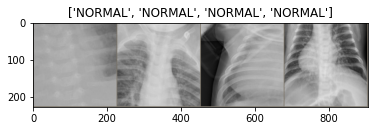

In [10]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [11]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [12]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

In [13]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.89
Valid  Acc: 0.87
#######################
Epoch:  2 / 30
Train  Acc: 0.93
Valid  Acc: 0.93
#######################
Epoch:  3 / 30
Train  Acc: 0.94
Valid  Acc: 0.89
#######################
Epoch:  4 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  5 / 30
Train  Acc: 0.94
Valid  Acc: 0.95
#######################
Epoch:  6 / 30
Train  Acc: 0.95
Valid  Acc: 0.91
#######################
Epoch:  7 / 30
Train  Acc: 0.95
Valid  Acc: 0.90
#######################
Epoch:  8 / 30
Train  Acc: 0.95
Valid  Acc: 0.92
#######################
Epoch:  9 / 30
Train  Acc: 0.96
Valid  Acc: 0.95
#######################
Epoch:  10 / 30
Train  Acc: 0.96
Valid  Acc: 0.93
#######################
Epoch:  11 / 30
Train  Acc: 0.96
Valid  Acc: 0.94
#######################
Epoch:  12 / 30
Train  Acc: 0.96
Valid  Acc: 0.94
#######################
Epoch:  13 / 30
Train  Acc: 0.97
Valid  Acc: 0.94
#######################
Epoch:  14 / 30
Train  Acc: 0.96
Valid  Acc: 0.

In [15]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

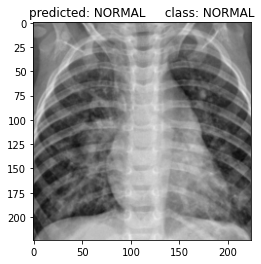

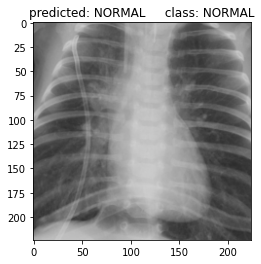

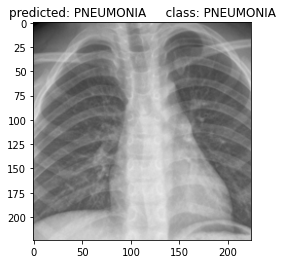

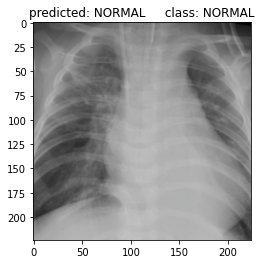

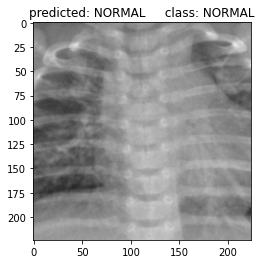

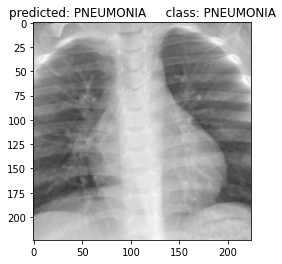

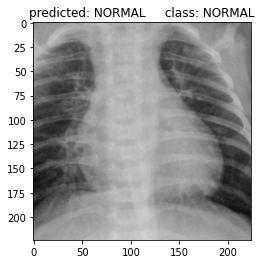

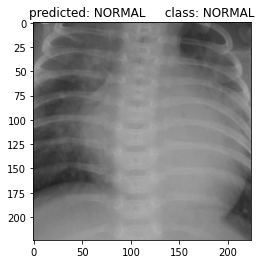

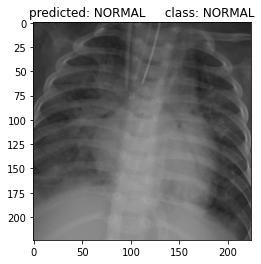

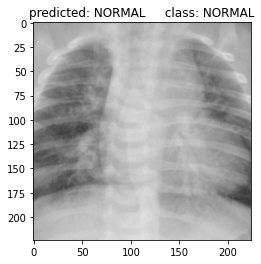

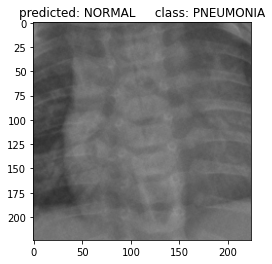

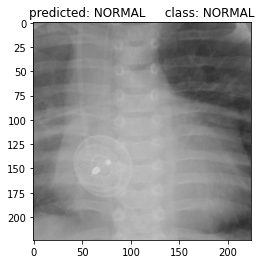

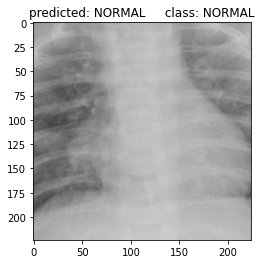

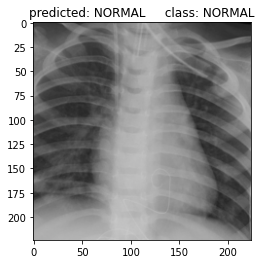

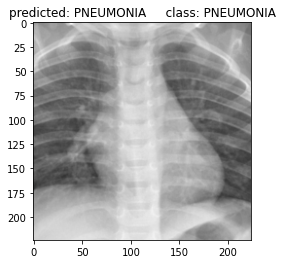

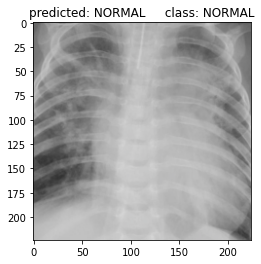

In [16]:
visualize_model(model)

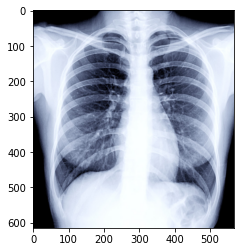

In [17]:
image = io.imread('https://d2ebzu6go672f3.cloudfront.net/media/content/images/cr/ddca3f92-4b8e-4672-bb6b-f3594ad4e304.jpg')
plt.imshow(image);

In [18]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [19]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [20]:
print('predicted: ' + dataset_labels[preds])

predicted: NORMAL


In [31]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [27]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

RuntimeError: ignored

In [25]:
cm = confusion_matrix(preds.reshape(-1),labels)

ValueError: ignored

In [26]:
print("Confusion Matrix : ")
cm


Confusion Matrix : 


NameError: ignored

Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [ ]:
cm[0,0]

70

In [ ]:
cm[1,1]

0

In [ ]:
cm[0,1]

83

In [ ]:
cm[1,0]

0